# A/B тест приложения для курьеров


## Описание данных:


| Поле                         | Описание                      |
| :----------------------------| :-----------------------------|
| order_id                     | id заказа                     |
| delivery_time                | время доставки в минутах      |
| district                     | район доставки                |
| experiment_group             | экспериментальная группа      | 


## Постановка задачи


Есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены доставка очень сильно проседает в эффективности. 

Data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Было решено провести A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Задача – проанализировать данные эксперимента и помочь бизнесу принять решение о распространении новой опции на всех курьеров.

<hr>

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import shapiro

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загрузим данные, посмотрим на их размерность и отобразим первые 5 строк
df = pd.read_csv('experiment.csv')
print(f'Размерность данных - {df.shape}')
df.head()

Размерность данных - (20196, 4)


,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


<hr>

### Для начала сформулируем гипотезы для проверки:


- **Нулевая гипотеза** $(H_0)$: Разницы между средним временем доставки в тестовой и контрольной группе нет
- **Альтернативная гипотеза** $(H_1)$: Разница между средним временем доставки в тестовой и контрольной группе есть

<hr>

### Посмотрим на распределения по экспериментальным группам

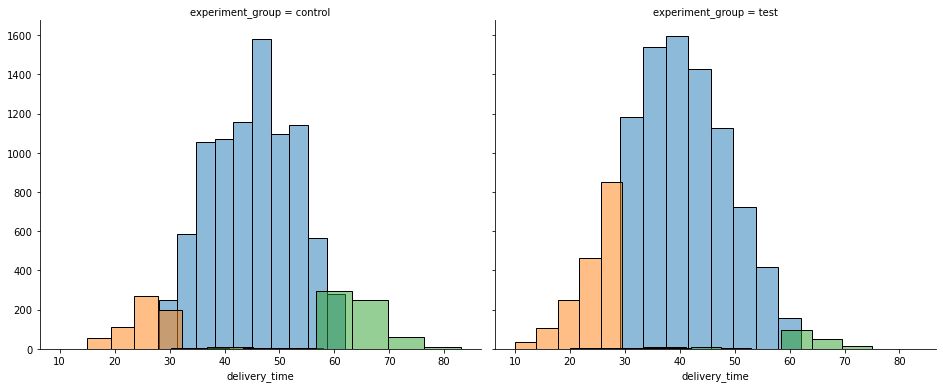

In [3]:
g = sns.FacetGrid(df, col='experiment_group', hue='district', height=5.5, aspect=1.2)
g.map(sns.histplot, 'delivery_time', bins=10, alpha=0.5);

### Далее изучим имеющиеся распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.


Сделаем семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля), так как на больших выборках можем получать неверные результаты.

Чувствительность любого теста зависит от размера выборки. Это касается и **теста Шапиро-Уилка** - на больших выборках он детектирует даже самые незначительные отклонения от нормальности. Поэтому мы берём случайные 1000 значений из выборки, чтобы обойти этот недостаток.

Есть шанс, что случайные 1000 значений всё же сформируют ненормальное распределение, поэтому будем использовать аргумент ```random_state=17``` для стабильности и воспроизводимости результатов.

In [4]:
# Формируем случайную выборку размером 1000 наблюдений из тестовой группы
test_df = df[df['experiment_group'] == 'test'].delivery_time
test_sample = test_df.sample(1000, random_state=17)
test_sample[:5]

17877    37.0
18499    39.0
16476    48.0
14602    30.0
16719    25.0
Name: delivery_time, dtype: float64

In [5]:
# Формируем случайную выборку размером 1000 наблюдений из контрольной группы
control_df = df[df['experiment_group'] == 'control'].delivery_time
control_sample = control_df.sample(1000, random_state=17)
control_sample[:5]

7144    42.0
6231    42.0
6902    41.0
7032    54.0
2009    44.0
Name: delivery_time, dtype: float64

**Нулевая гипотеза** $(H_0)$: распределение является нормальным.<br>
**Альтернативная гипотеза** $(H_1)$: распределение отклоненяется от нормальнольного.

In [6]:
# Применим тест Шапиро-Уилка для выборки из тестовой группы
shapiro(test_sample)

ShapiroResult(statistic=0.9975475668907166, pvalue=0.14005419611930847)

$p$-значение > $0.05$, таким образом **отклоняем альтернативную** гипотезу и принимаем нулевую гипотезу

In [7]:
# Применим тест Шапиро-Уилка для выборки из контрольной группы
shapiro(control_sample)

ShapiroResult(statistic=0.9974725842475891, pvalue=0.12411931157112122)

$p$-значение $> 0.05$, таким образом **отклоняем альтернативную** гипотезу и принимаем нулевую гипотезу

In [8]:
# Посчитаем стандартное отклонение в тестовой группе
test_df.std()

9.883308351129031

In [9]:
# Посчитаем стандартное отклонение в контрольной группе
control_df.std()

9.990016960247171

Таким образом, значения в тестовой группе распределены **НОРМАЛЬНО**. Стандартное отклонение времени доставки в тесте равно 9,88. В контрольной группе распределение является **НОРМАЛЬНЫМ**. Стандартное отклонение времени доставки в контроле равно 9,99.

<hr>

### Используя t-критерий, проверим, можно ли считать различия времени доставки в тестовой и контрольной группах статистически достоверными.

In [10]:
ttest_ind(test_df, control_df)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

**Отклоняем нулевую гипотезу о равенстве средних** $p < 0,05$

<hr>

### Посмотрим на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной.

In [11]:
f'{(test_df.mean() - control_df.mean())/control_df.mean():.2%}'

'-13.35%'

**Таким образом, новый алгоритм можем внедрять для использования всеми курьерами, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.**